In [5]:
import warnings
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import theano.tensor as tt

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D


from scipy import signal
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars

import helpers
import pysindy as ps
from pysindy.utils import lorenz, lorenz_control, enzyme

In [4]:

invlogit = lambda x: 1/(1 + tt.exp(-x))
x = np.linspace(-1,1,100)
invlogit(x)
# plt.plot(x,)

Elemwise{true_div,no_inplace}.0

In [6]:
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)


# Make plots of the data and its time derivative
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["x", "y", "z"]
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    return x_dot



# Make an errorbar coefficient plot from the results of ensembling
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(10):
        xticknames[i] = "$" + xticknames[i] + "$"
    plt.figure(figsize=(18, 4))
    colors = ["b", "r", "k"]
    plt.subplot(1, 2, 1)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.subplot(1, 2, 2)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(3):
        plt.errorbar(
            range(10),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc="upper right")
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment="top")


# Make energy-preserving quadratic constraints for model of size r
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
            ] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)
            ] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[
                    q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix


# For Trapping SINDy, use optimal m, and calculate if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print("optimal m: ", opt_m)
    print("As eigvals: ", np.sort(eigvals))
    print(
        "All As eigenvalues are < 0 and therefore system is globally stable? ",
        np.all(eigvals < 0),
    )
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print("Estimate of trapping region size, Rm = ", Rm)


# Plot Kuramoto-Sivashinsky data and its derivative
def plot_u_and_u_dot(t, x, u):
    dt = t[1] - t[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(t, x, u[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    plt.title(r"$u(x, t)$", fontsize=16)
    u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(t, x, u_dot[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r"$\dot{u}(x, t)$", fontsize=16)
    plt.show()
    return u_dot


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(
                t_test, x_dot_test_computed[:, i], "k", 
                label="numerical derivative"
            )
            plt.plot(t_test, x_dot_test_predicted[:, i], "r", 
                     label="model prediction")
            if j == 0:
                plt.ylabel("$\dot " + feature_names[i] + r"$", fontsize=20)
            if i == 0:
                plt.title(
                    "MSE = %.0f" % model.score(x_test, 
                                               t=dt, 
                                               metric=mean_squared_error),
                    fontsize=16,
                )
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_fits(x_test, optimizer, t_test, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint
        # rather than the default solve_ivp, which crashes with an error
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], "k", label="test trajectory")
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for unstable systems
                plt.plot(t_test, x_test_sim[:, i], "r", label="model prediction")
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# Make 3d plots comparing a test trajectory, 
# an associated model trajectory, and a second model trajectory.
def make_3d_plots(x_test, x_sim, constrained_x_sim, last_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    plt.plot(
        x_test[:, 0],
        x_test[:, 1],
        x_test[:, 2],
        "k",
        label="Validation Lorenz trajectory",
    )
    plt.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "r", 
             label="SR3, no constraints")
    plt.plot(
        constrained_x_sim[:, 0],
        constrained_x_sim[:, 1],
        constrained_x_sim[:, 2],
        "b",
        label=last_label,
    )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(fontsize=16, framealpha=1.0)
    plt.show()

# Loading in Data and Starting SINDy Learning

In [8]:
inf_data = pd.read_csv("Infiltration.csv")
inf_data.shape

t = np.asarray(inf_data["Time (s)"])
x = np.asarray(inf_data["Height (mm)"])/1000

array([[0.03943414, 1.        , 0.03943414],
       [0.03743295, 1.        , 0.03743295],
       [0.03580655, 1.        , 0.03580655],
       [0.03492975, 1.        , 0.03492975],
       [0.03480255, 1.        , 0.03480255],
       [0.03542494, 1.        , 0.03542494],
       [0.03679693, 1.        , 0.03679693],
       [0.03891851, 1.        , 0.03891851],
       [0.04178968, 1.        , 0.04178968],
       [0.04541045, 1.        , 0.04541045],
       [0.04978082, 1.        , 0.04978082],
       [0.05490078, 1.        , 0.05490078],
       [0.06404995, 1.        , 0.06404995],
       [0.07275715, 1.        , 0.07275715],
       [0.07950843, 1.        , 0.07950843],
       [0.086166  , 1.        , 0.086166  ],
       [0.09289853, 1.        , 0.09289853],
       [0.10224012, 1.        , 0.10224012],
       [0.11253761, 1.        , 0.11253761],
       [0.12261767, 1.        , 0.12261767],
       [0.13411472, 1.        , 0.13411472],
       [0.14160448, 1.        , 0.14160448],
       [0.

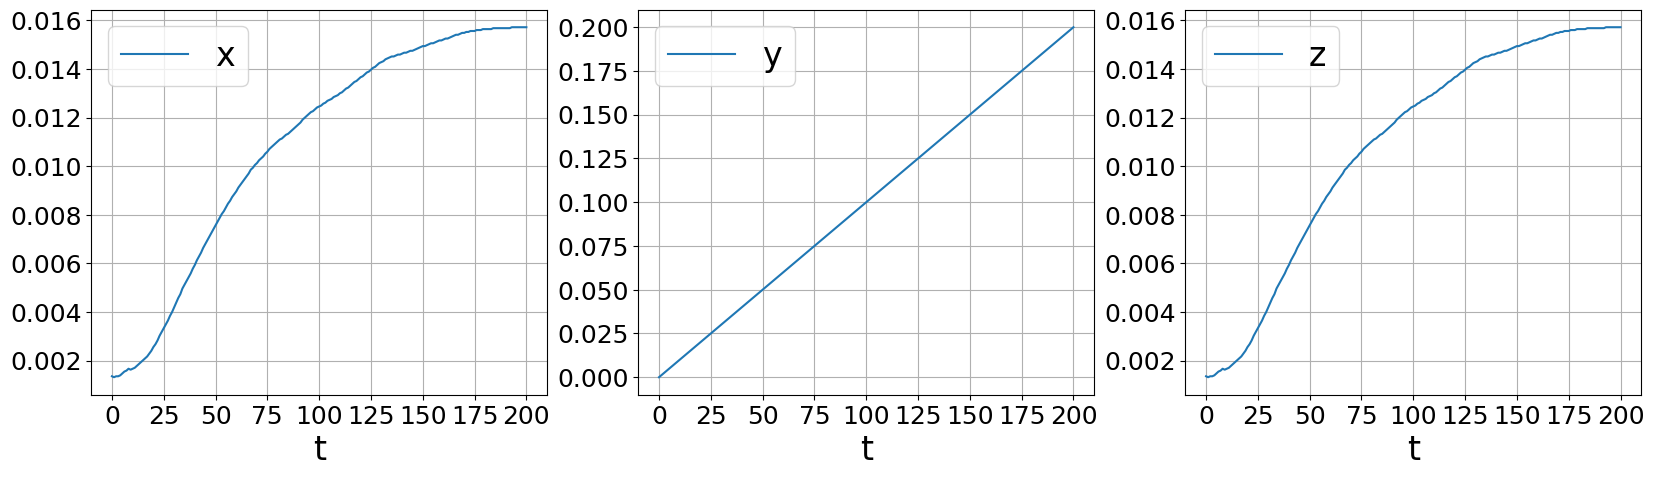

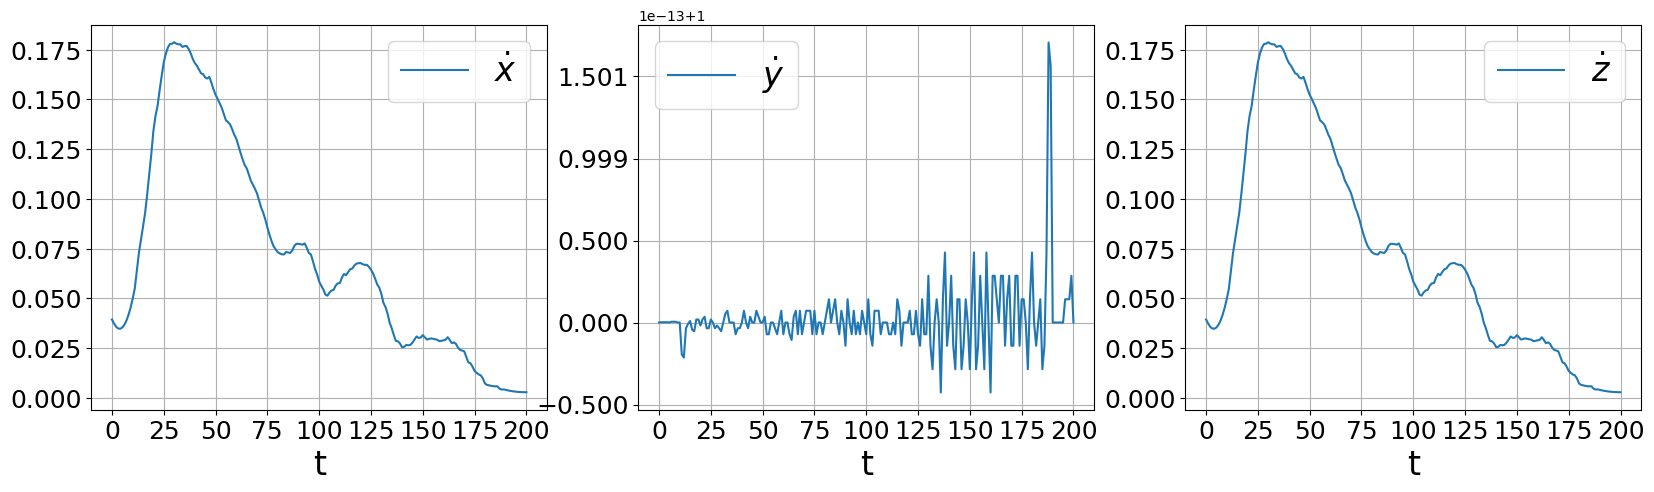

In [9]:
X1 = np.stack((x,t,x), axis =-1)
plot_data_and_derivative(X1, t, ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': 25})._differentiate)

In [6]:
spline = ps.SINDyDerivative(kind="spline", s=1.3e-1)#s=1e-2
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': 25})
fd = ps.FiniteDifference()

diff = ps.SINDy(differentiation_method=smoothed_fd)
diff.differentiate(x_test, t=dt)

x_d1 = diff.differentiate(x,t).reshape(-1) # dx/dt
x_d2 = diff.differentiate(x_d1,t).reshape(-1) # d2x/dx2
x_d3 = diff.differentiate(x_d2, t).reshape(-1) # d3x/dx3
x_d1sq = x_d1**2

inf_data["l'"] = x_d1
inf_data["l''"] = x_d2
inf_data ["l'''"] = x_d3

NameError: name 'x_test' is not defined

In [ ]:
# differentiation_method = ps.SmoothedFiniteDifference(order=2)

Poly_lib = ps.PolynomialLibrary(degree=2)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(0.02)#threshold = 0.3)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names=["l", "l''", "l'sq"] 
)

X_2 = np.stack((x, x_d2, x_d1sq), axis = -1) 

model.fit(X_2, t=t)
model.print()

l0 = x[0]
lt0 = x_d1[0]
ltt0 = x_d2[0]
ltsq0 = x_d1sq[0]

In [ ]:
t0 = t[0]
sim = model.simulate([l0, ltt0, ltsq0], t=t)
model.get_feature_names()

RMSE = mean_squared_error(x, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

In [ ]:
plt.ion()

plt.figure()
plt.plot(t[0], l0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t, X_2[:,0], "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)
plt.title("All data model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

In [ ]:
differentiation_method = ps.SmoothedFiniteDifference(order=2,smoother_kws={'window_length': 25})
# x_dot = differentiation_method(x)
# plt.plot(t,x_dot)

Poly_lib = ps.PolynomialLibrary(degree=2)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(threshold=0.01)

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names=["l", "t"],
)

X = np.stack((x, t), axis=-1)

model.fit(X, t=t)
model.print()
model.get_feature_names()

In [ ]:
x0 = x[0]
t0 = t[0]
sim = model.simulate([x0,t0], t=t)

RMSE = mean_squared_error(x, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

In [ ]:
plt.ion()
plt.figure()
plt.plot(t[0], x0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t, x, "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)

plt.title("Best fit model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

### Creating the library of differential equations 

In [ ]:
dt = t
x_train = X1
x_test = X1
t_test = dt
feature_names = ['l', 't', 'l']
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

In [ ]:
threshold_scan = np.linspace(0.3, 0.7, 10)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_names=feature_names, 
                     optimizer=sparse_regression_optimizer)
    model.fit(x_train, t=dt, quiet=True)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, 
            threshold_scan, x_test, t_test)

### Ensemble method

In [ ]:
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, ensemble=True, quiet=True)
ensemble_coefs = model.coef_list

# Get average and standard deviation of the ensemble model coefficients
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, quiet=True)
library_ensemble_coefs = model.coef_list

# Get average and standard deviation of the library ensemble model coefficients
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [ ]:
plot_ensemble_results(
    model, 
    mean_ensemble, 
    std_ensemble, 
    mean_library_ensemble, 
    std_library_ensemble
)

# ** Post Meeting Implementation (Feb/01/2023) **
### Tasks
- Use sindy to recover the model using data up to 1s (Done)
- Only use the features in the reference equation to discover the model
- Gradually increase the redundant terms in the model and observe the discovered models
- Simulate the true model, add some noise and use sindy to recover the model

## ** Using SINDy to recover the model using data up to 1s **

### Reloading the data

In [7]:
inf_data = pd.read_csv("Infiltration.csv")

In [8]:
t = np.asarray(inf_data["Time (s)"])
x_mm = np.asarray(inf_data["Height (mm)"])
x = x_mm*(10**-3)
X = np.stack((x, t), axis=-1)


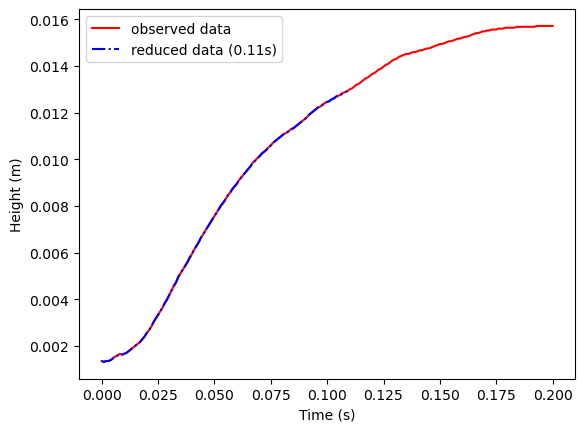

In [12]:
# t.tolist().index(0.11) # get index of the 0.11 element
t_red = t[:110] # reduced time length up to 0.1s
x_red = x[:110]
X_red = np.stack((x_red, t_red), axis=-1)
df_red = pd.DataFrame()
df_red['t_red'] = t_red 
df_red['x_red'] = x_red
x_test = x_red

plt.plot(t, x, 'r-',label = "observed data")
plt.plot(t_red, x_red, 'b-.',label = "reduced data (0.11s)")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

array([[0.00103884, 1.        , 0.00103884],
       [0.00670533, 1.        , 0.00670533],
       [0.01239945, 1.        , 0.01239945],
       [0.01814886, 1.        , 0.01814886],
       [0.02395353, 1.        , 0.02395353],
       [0.02981349, 1.        , 0.02981349],
       [0.03572871, 1.        , 0.03572871],
       [0.04169922, 1.        , 0.04169922],
       [0.047725  , 1.        , 0.047725  ],
       [0.05380605, 1.        , 0.05380605],
       [0.05994238, 1.        , 0.05994238],
       [0.06613399, 1.        , 0.06613399],
       [0.07238087, 1.        , 0.07238087],
       [0.07868303, 1.        , 0.07868303],
       [0.08504047, 1.        , 0.08504047],
       [0.09145317, 1.        , 0.09145317],
       [0.09792116, 1.        , 0.09792116],
       [0.10634974, 1.        , 0.10634974],
       [0.11455376, 1.        , 0.11455376],
       [0.12184087, 1.        , 0.12184087],
       [0.12917292, 1.        , 0.12917292],
       [0.1350165 , 1.        , 0.1350165 ],
       [0.

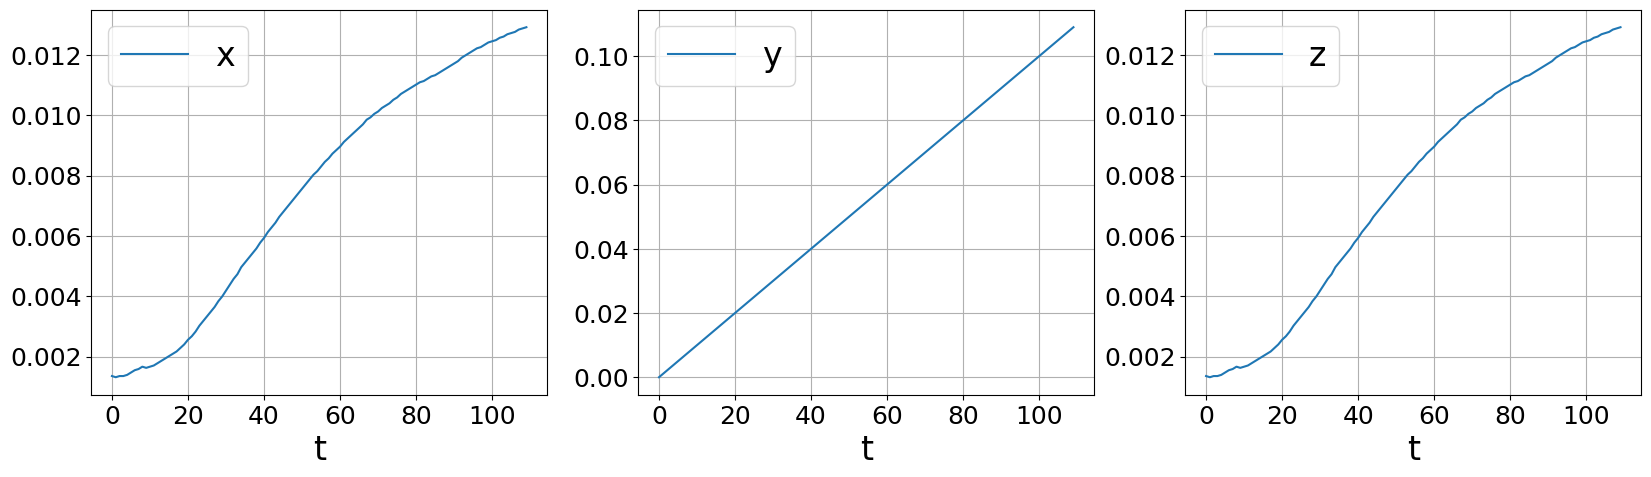

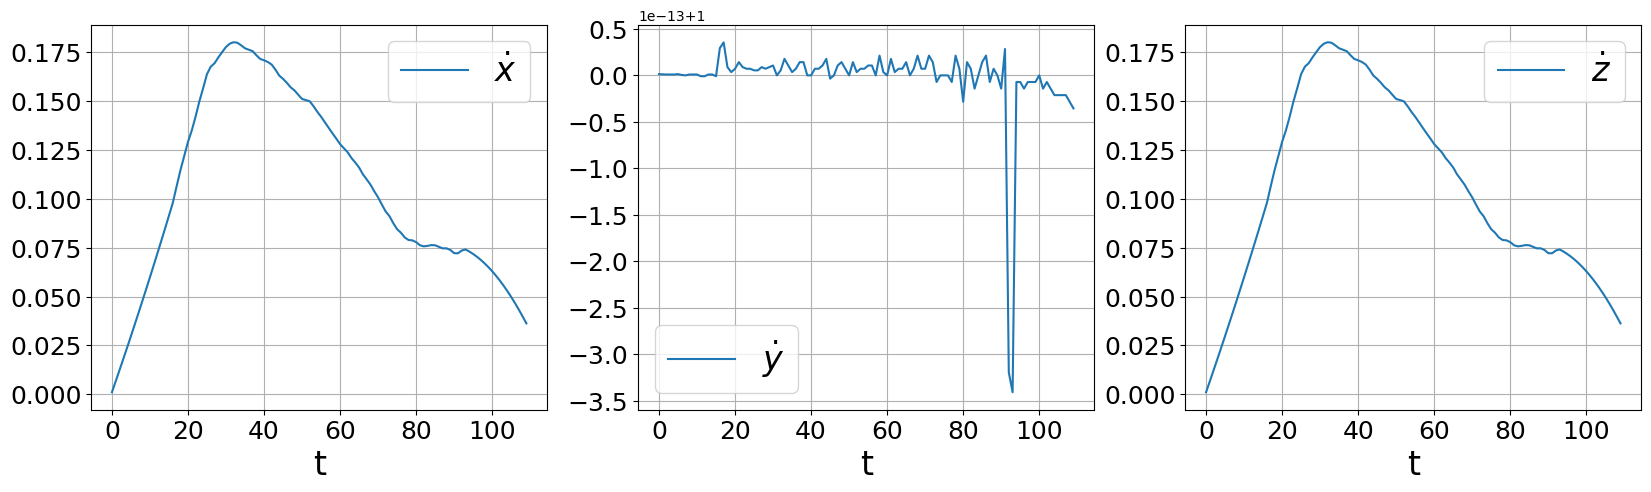

In [13]:
diffs = [
    ("PySINDy Finite Difference", ps.FiniteDifference()),
    ("Finite Difference", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("Smoothed Finite Difference", ps.SmoothedFiniteDifference()),
    (
        "Savitzky Golay",
        ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3),
    ),
    ("Spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("Trend Filtered", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("Spectral", ps.SINDyDerivative(kind="spectral")),
    ("Spectral, PySINDy version", ps.SpectralDerivative()),
]

X1 = np.stack((x_red,t_red,x_red), axis =-1)
plot_data_and_derivative(X1, t_red, ps.SmoothedFiniteDifference(smoother_kws={'window_length': 35})._differentiate)

### Creating Differential Terms

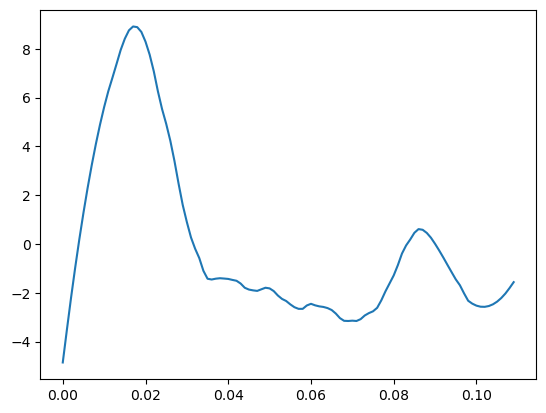

In [15]:
spline = ps.SINDyDerivative(kind="spline", s=1.3e-1)#s=1e-2
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': 25})
fd = ps.SmoothedFiniteDifference()

diff = ps.SINDy(differentiation_method=smoothed_fd)
diff.differentiate(x_test, t_red)

x_d1 = diff.differentiate(x_red,t_red).reshape(-1) #differentiation_method(x_red,t_red) # dx/dt
x_d2 = diff.differentiate(x_d1,t_red).reshape(-1)  #differentiation_method2(x_d1) # d2x/dx2
x_d3 = diff.differentiate(x_d2,t_red).reshape(-1)  #differentiation_method2(x_d2) # d3x/dx3
x_d1sq = x_d1**2

df_red["l'"] = x_d1
df_red["l''"] = x_d2
df_red ["l'''"] = x_d3

plt.plot(t_red, x_d2)

In [16]:
Poly_lib = ps.PolynomialLibrary(degree=2)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(threshold=0.02)

# differentiation_method=smoothed_fd,
X2 = np.stack((x_red, x_d2, x_d1sq), axis = -1)
X3 = np.stack((x_red, x_d2, x_d3), axis = -1)

model = ps.SINDy(differentiation_method=smoothed_fd,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names=["l","l''", "l'sq"] 
)

model.fit(X2, t=t_red) #, library_ensemble = True)
model.print()
# model.get_feature_names()

(l)' = 0.029 1 + 0.668 l + 7.370 l'sq + 0.103 l l'' + -89.506 l'sq^2
(l'')' = 868.396 1 + 255343.973 l + -52.225 l'' + -125797.579 l'sq + -23996080.265 l^2 + 3861.694 l l'' + 787624.231 l l'sq + 4.491 l''^2 + -1741.147 l'' l'sq + 1988755.711 l'sq^2
(l'sq)' = 1.905 l + 0.116 l'' + -1.151 l'sq + -0.199 l l'' + 7.702 l'' l'sq


In [17]:
l0 = x_red[0]
lt0 = x_d1[0]
ltt0 = x_d2[0]
lttt_0 = x_d3[0]
lsq0 = x_d1sq[0]


sim = model.simulate([l0,ltt0,lsq0], t=t_red)
RMSE = mean_squared_error(x_red, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 5.1296954286804686e-05


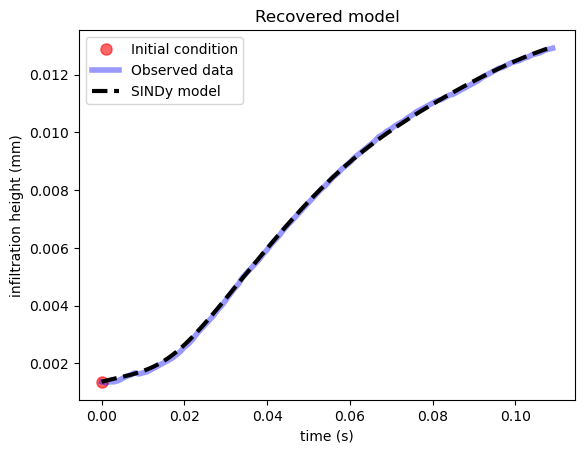

In [18]:
x0 = x_red[0]
t0 = t_red[0]

plt.ion()

plt.figure()
plt.plot(t0, x0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t_red, x_red, "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t_red, sim[:, 0], "k--", label="SINDy model", linewidth=3)

plt.title("Recovered model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

## ** Use features in the differential equation to create the library **

In [20]:
t_ = np.asarray(inf_data["Time (s)"])
x_mm = np.asarray(inf_data["Height (mm)"])
x_ = x_mm*(10**-3)
X = np.stack((x, t), axis=-1)

x = x_[:110]
t = t_[:110]
spline = ps.SINDyDerivative(kind="spline", s=1.3e-1)#s=1e-2
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': 25})
fd = ps.SmoothedFiniteDifference()

diff = ps.SINDy(differentiation_method=smoothed_fd)
diff.differentiate(x_test, t=t)

x_t = diff.differentiate(x,t).reshape(-1) #differentiation_method(x_red,t) # dx/dt
x_tt = diff.differentiate(x_t,t).reshape(-1)  #differentiation_method2(x_t) # d2x/dx2

x_tsq = x_t**2

# df_red["l'"] = x_t
# df_red["l''"] = x_tt

In [21]:
#Creating Reference features
Lltt = x*x_tt  #L*l''
lt_sq = x_t**2 # l' squared
Llt = x*x_t 
L = x
x_train = np.stack((L,Llt,lt_sq,Lltt), axis = -1)

In [22]:
Poly_lib = ps.PolynomialLibrary(degree=1, include_interaction=False)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(threshold=0.02)

model = ps.SINDy(differentiation_method=smoothed_fd,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names=["L","L(dx/dt)", "(dx/dt)2", "L(d2x/dx2)"] 
)

model.fit(x_train, t=t) #, library_ensemble = True)
model.print()
# model.get_feature_names()

(L)' = 0.038 1 + 1.072 L + 4.548 (dx/dt)2 + 0.077 L(d2x/dx2)
(L(dx/dt))' = -0.003 L + 0.993 (dx/dt)2 + 0.996 L(d2x/dx2)
((dx/dt)2)' = 0.349 1 + 100.723 L + -1520.492 L(dx/dt) + 25.561 (dx/dt)2 + 33.702 L(d2x/dx2)
(L(d2x/dx2))' = 2.044 1 + -25.157 L + -1807.132 L(dx/dt) + -57.844 (dx/dt)2 + -22.528 L(d2x/dx2)


In [23]:
l0 = L[0]
Llt0 = Llt[0]
lt_sq0 = lt_sq[0]
Lltt0 =Lltt[0]


sim = model.simulate([l0,Llt0,lt_sq0,Lltt0], t=t)
RMSE = mean_squared_error(x, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 0.0002887745547219491


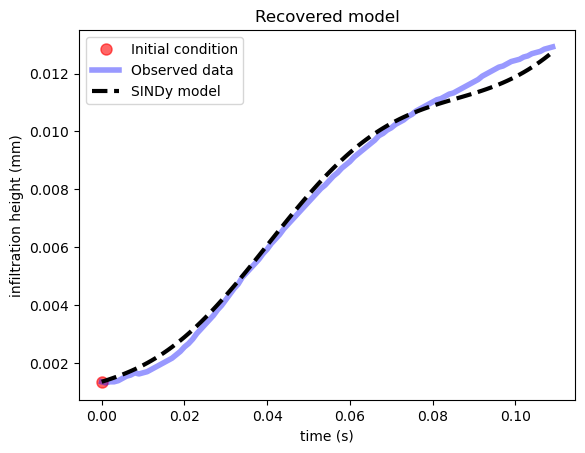

In [24]:
x0 = x[0]
t0 = t[0]

plt.ion()

plt.figure()
plt.plot(t0, x0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t, x, "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)

plt.title("Recovered model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

## ** Gradually increase redundant terms in the model **

In [25]:
Poly_lib = ps.PolynomialLibrary(degree=2, include_interaction=True)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(threshold=0.02)

model = ps.SINDy(differentiation_method=smoothed_fd,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names=["L","L(dx/dt)", "(dx/dt)2", "L(d2x/dx2)"] 
)

model.fit(x_train, t=t) #, library_ensemble = True)
model.print()
# model.get_feature_names()



(L)' = 0.029 1 + 0.668 L + 7.370 (dx/dt)2 + 0.103 L(d2x/dx2) + -89.506 (dx/dt)2^2
(L(dx/dt))' = -0.003 L + 0.993 (dx/dt)2 + 0.996 L(d2x/dx2)
((dx/dt)2)' = -0.248 1 + 64.551 L + -150.099 L(dx/dt) + 98.574 (dx/dt)2 + 76.869 L(d2x/dx2) + -3609.831 L^2 + -5744.399 L (dx/dt)2 + -5668.448 L L(d2x/dx2) + -2099.123 (dx/dt)2^2 + 318.991 (dx/dt)2 L(d2x/dx2)
(L(d2x/dx2))' = 0.541 1 + 765.405 L + -15499.324 L(dx/dt) + 646.716 (dx/dt)2 + -31.859 L(d2x/dx2) + 10147.141 L (dx/dt)2 + -14990.270 (dx/dt)2^2 + -6340.713 (dx/dt)2 L(d2x/dx2) + -2409.672 L(d2x/dx2)^2


In [26]:
l0 = L[0]
Llt0 = Llt[0]
lt_sq0 = lt_sq[0]
Lltt0 =Lltt[0]


sim = model.simulate([l0,Llt0,lt_sq0,Lltt0], t=t)
RMSE = mean_squared_error(x, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

Root Mean Square Error: 0.0004311817015894061


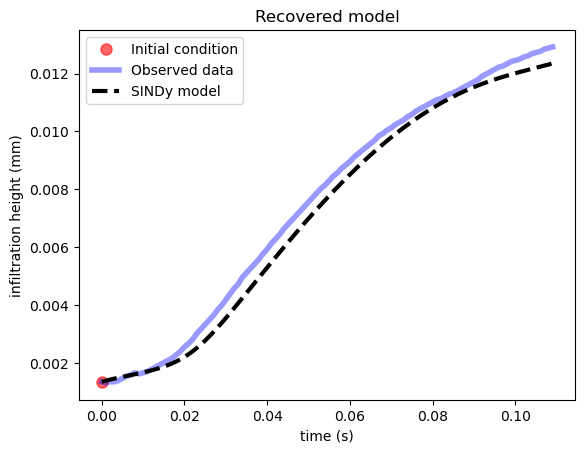

In [27]:
x0 = x[0]
t0 = t[0]

plt.ion()

plt.figure()
plt.plot(t0, x0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t, x, "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t, sim[:, 0], "k--", label="SINDy model", linewidth=3)

plt.title("Recovered model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

## ** Simulate the true model, add some noise and use sindy to recover the model **

In [28]:
g = 9.8
K = 5.934*(10**(-8))
Pc = 61.9164
rho_l = 780
mu = 0.0012

In [29]:
l_model = pd.read_csv("length.csv")
t_model = pd.read_csv("time.csv")


st = 0
t_mod = (np.array(t_model/1000)).reshape(-1)[st:]
l_mod = np.array(l_model/1000).reshape(-1)[st:]

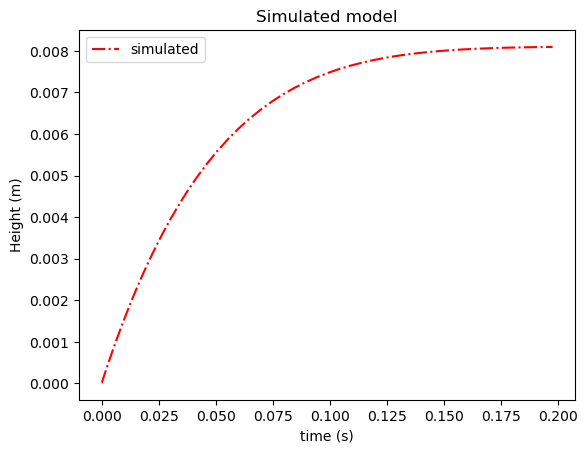

In [30]:
plt.plot(t_mod,l_mod, 'r-.', label = 'simulated')

plt.title("Simulated model")
plt.xlabel("time (s)")
plt.ylabel("Height (m)")
plt.legend()
plt.show()

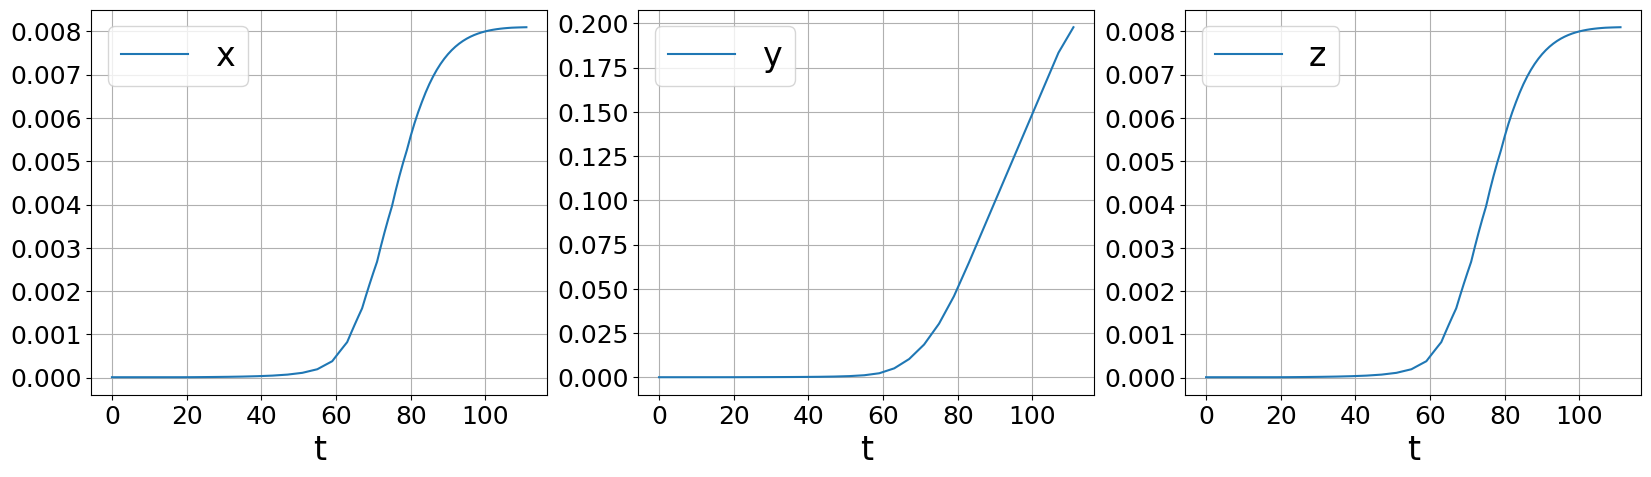

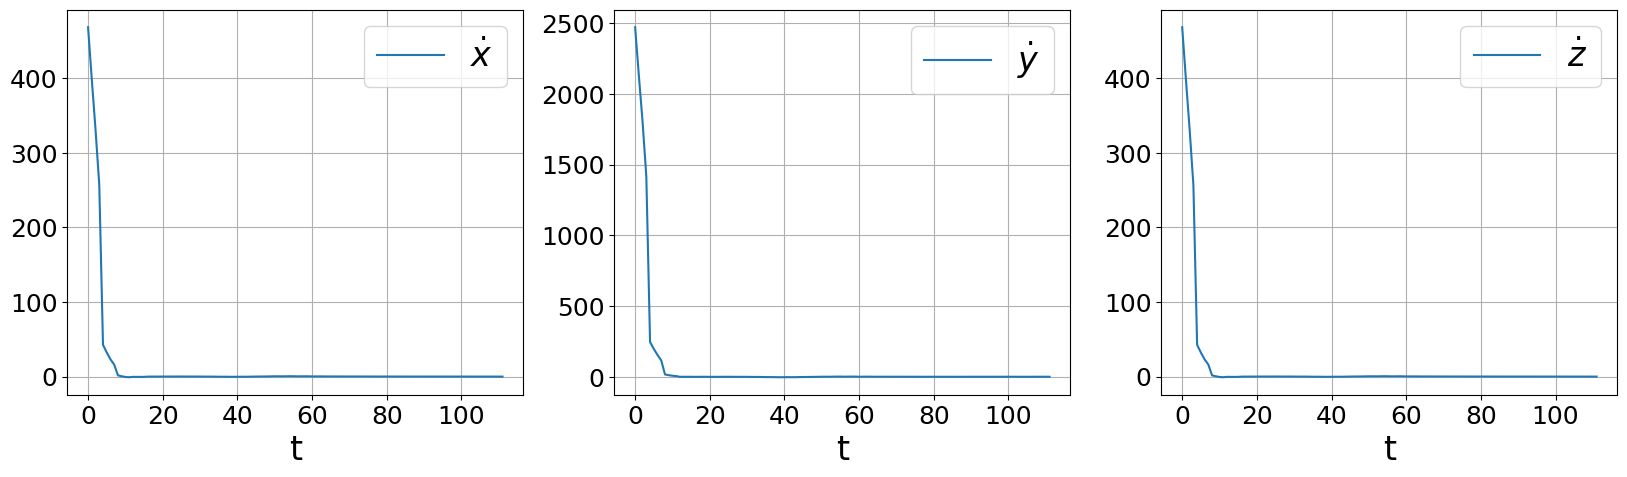

In [31]:
diffs = [
    ("PySINDy Finite Difference", ps.FiniteDifference()),
    ("Finite Difference", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("Smoothed Finite Difference", ps.SmoothedFiniteDifference()),
    (
        "Savitzky Golay",
        ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3),
    ),
    ("Spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("Trend Filtered", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("Spectral", ps.SINDyDerivative(kind="spectral")),
    ("Spectral, PySINDy version", ps.SpectralDerivative()),
]

X1 = np.stack((l_mod,t_mod,l_mod), axis =-1)
X_dot = plot_data_and_derivative(X1, t_mod, ps.SmoothedFiniteDifference(smoother_kws={'window_length': 50})._differentiate)

### Model recovery for actual model data

In [32]:
# Creating Differential terms 

spline = ps.SINDyDerivative(kind="spline", s=1.3e-1)#s=1e-2
smoothed_fd = ps.SmoothedFiniteDifference(order=2, smoother_kws={'window_length': 50})
fd = ps.SmoothedFiniteDifference()

diff = ps.SINDy(differentiation_method=smoothed_fd).differentiate

x_t = diff(l_mod,t_mod).reshape(-1) #differentiation_method(x_red,t) # dx/dt
x_tt = diff(x_t,t_mod).reshape(-1)  #differentiation_method2(x_t) # d2x/dx2

# x_tsq = x_t**2
# plt.plot(t_mod,x_t)
# plt.grid(True)
# plt.show()

AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'

In [71]:
def diff_l(t,L):
    L_dot = 22.841 - 3351.165*L
    return L_dot

def integ(x,t):
    return x*t + 468.3408415203826

t_solve = np.linspace(0,0.2,112)
sol = solve_ivp(diff_l, t_span=[t_mod[0], t_mod[-1]], y0= [L[0]], t_eval=t_mod).y
sol = sol[0,:]

In [72]:
#creating custom library
library_functions = [
    lambda x : np.ones_like(x),
    lambda x : x,
    lambda x,y : diff(x,y).reshape(-1),
    lambda x,y : diff(diff(x,y).reshape(-1),y).reshape(-1),
]
library_function_names = [
    lambda x : '1',
    lambda x :  x,
    lambda x,y : x  + y,
    lambda x,y : x  + y + y,
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names, include_bias=False
)


In [48]:
#Creating Reference features
Lltt = l_mod*x_tt  #L*l''
lt_sq = x_t**2 # l' squared
Llt = l_mod*x_t 
L = l_mod
x_train = np.stack((L,Llt, lt_sq, Lltt), axis = -1)

In [49]:
Poly_lib = ps.PolynomialLibrary(degree=1, include_interaction=False)
Fourier_lib = ps.FourierLibrary()
Tensor_library = Poly_lib + Fourier_lib 
optimizer = ps.STLSQ(threshold=0.02, verbose=False)
sr3_optimizer = ps.SR3(threshold=0.1, thresholder='l2')

model = ps.SINDy(differentiation_method=smoothed_fd,
    feature_library=Poly_lib,
    optimizer=optimizer,
    feature_names= ["L", "Ldl", "dl2", "Ld2l"]  #["L","L(dx/dt)", "(dx/dt)2", "L(d2x/dx2)"] 
)

model.fit(x_train, t=t_mod) #, library_ensemble = True)
model.print()
# model.get_feature_names()
# library.get_feature_names()

(L)' = -4.392 1 + -848.568 L + 88486.055 Ldl
(Ldl)' = -3.038 1 + 42.648 L + 23873.035 Ldl + 0.998 Ld2l
(dl2)' = 425176880.862 1 + -35735842933.475 L + -1576855566065.232 Ldl + -317265.765 dl2 + 35104193.284 Ld2l
(Ld2l)' = 650231297.465 1 + -56623354248.855 L + -2300332336193.187 Ldl + -442682.145 dl2 + -55793132.101 Ld2l


In [50]:
l0 = L[0]
Llt0 = Llt[0]
lt_sq0 = lt_sq[0]
Lltt0 =Lltt[0]


sim = model.simulate([l0, Llt0, lt_sq0, Lltt0], t=t_mod)
RMSE = mean_squared_error(l_mod, sim[:,0], squared = False)
print("Root Mean Square Error:", RMSE)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: x and y must have same first dimension, but have shapes (112,) and (110,)

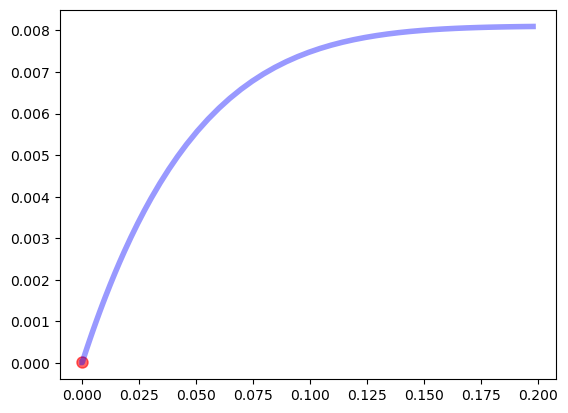

In [51]:
x0 = l_mod[0]
t0 = t_mod[0]

plt.ion()

plt.figure()
plt.plot(t0, x0, "ro", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t_mod, l_mod, "b", label="Observed data", alpha=0.4, linewidth=4)
plt.plot(t_mod, sim[:, 0], "k--", label="SINDy model", linewidth=3)
plt.plot(t_mod, sol, 'g')

plt.title("Recovered model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (mm)")
plt.legend()
plt.show()

### Comparing Experimental data to Simulated data

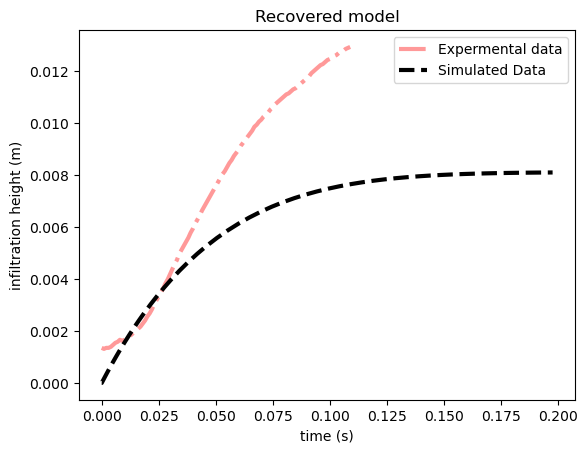

In [52]:
plt.ion()

plt.figure()
# plt.plot(t0, x0, "bo", label="Initial condition", alpha=0.6, markersize=8)
plt.plot(t, x, "r-.", label="Expermental data", alpha=0.4, linewidth=3)
plt.plot(t_mod, l_mod, "k--", label="Simulated Data", linewidth=3)

plt.title("Recovered model")
plt.xlabel("time (s)")
plt.ylabel("infiltration height (m)")
plt.legend()
plt.show()

### Simulating Model differently

In [53]:
from scipy.integrate import odeint

In [55]:
def f(U,t):
    rho_1 = 780
    g = 9.8
    mu = 11.7*10**(-4)
    K = 5.93 * 10**(-8) 
    Pc = 61.9164
    L = U[0] 
    L_dot = U[1]
    val = (1/(rho_1*L))*(Pc - rho_1*g*L - (mu/K)*L*L_dot - rho_1*(L_dot)**2)
    return (U[1], val)

In [68]:
u0 = [0,1.358]
ts = np.linspace(0,0.5,20) 
Us = odeint(f,u0,ts)

C:\Users\USER\AppData\Local\Temp\ipykernel_21560\2947444256.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  val = (1/(rho_1*L))*(Pc - rho_1*g*L - (mu/K)*L*L_dot - rho_1*(L_dot)**2)


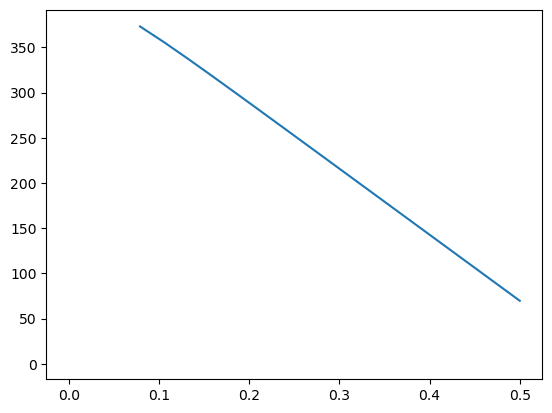

In [70]:
plt.plot(ts,Us[:,1])

In [5]:
import matplotlib.pyplot as plt